# Assignment #2 - Classification

<font color="red"> <b> Due: Oct 23 (Friday) 11:00 pm </b> </font>

<font color="blue"> Zachary Hamilton </font>

# I. Introduction

The objective of this assignment was to implement 4 different methods of machine learning classification that we had previously implemented in our notes. It is in using these notes that I was able to complete most of the assignments. I did find a fairly severe issue with my softmax function for logistic regression that required me to do some research along with some help from the TA's to reimplement correctly. My pocket, QDA and LDA all came pretty much exclusively from my notes with minor changes. Overall I gained a much better understanding of what each of these algorithms is accomplishing and how its doing so. Furthermore, I found some spots where I need to do more future research to fully grasp some concepts.

# II. Data

The data I used for this assignment was games of chess played on lichess.com with plans to classify the data on the wins collumn as black win or white win. It had ~20,000 data samples with 16 features. Like last assignment I reduced the number of samples to a random 10,000 in order to save on processing time. I also droped several features such as game id start and end times the ids of the players and the opening stats that I felt had little to no effect on the outcome of the game. I also decided to drop the moves collumn that you could most likely use to predict the outcome of the game with extremely high acuracy due to how dense and complex the information was in that single collumn. For my visualizations I simply wanted to confirm that my random sample adhered to some of the general rules I knew about chess such as white wins more often and in less moves due to going first. The first two of my bar graphs confirmed these rules for every random sample I pulled during my testing. The final plot was to simply look at the comparisons of the matchups to see how equaly matched each oponent was. For the most part they were relatively close with a bit of outlier noise in some parts.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
from mpl_toolkits.mplot3d import Axes3D

#list of temperature data with 13 features in order to use regression to predict permanent magnet surface temperature aka rotor temperature (pm collumn)
data = pd.read_csv('games.csv')
data = data[data.winner != 'draw']
data['victory_status'] = pd.factorize(data['victory_status'])[0] 
data['winner'] = pd.factorize(data['winner'])[0] 
data['increment_code'] = pd.factorize(data['increment_code'])[0]
data['rated'] = pd.factorize(data['rated'])[0] 
random_sample = data.sample(10000)
random_sample =random_sample.drop(['id','created_at','last_move_at','white_id','black_id','moves','opening_eco','opening_name',],axis=1)
#pre-processing
random_sample.fillna(-1)
classes = random_sample.winner
classes[classes==0] =-1
random_sample = random_sample.drop('winner',axis=1)  
print("Done with pre-processing")

Done with pre-processing


Text(0.5, 1.0, 'Number of wins')

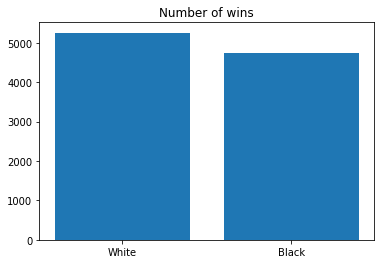

In [2]:
plt.bar(['White','Black'],[np.where(classes == -1)[0].size,np.where(classes == 1)[0].size])
plt.title('Number of wins')

<function matplotlib.pyplot.show(*args, **kw)>

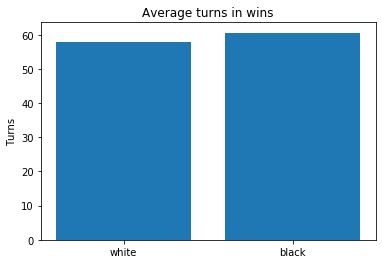

In [3]:
whitecount=0
whiteturn=0
blackcount=0
blackturn=0
index = 0
for winner in classes:
    if winner==-1:
        whitecount+=1
        whiteturn+=random_sample.turns.iloc[index]
    elif winner ==1 :
        blackcount+=1
        blackturn+=random_sample.turns.iloc[index]
    index+=1
plt.bar(['white','black'],[(whiteturn/whitecount),(blackturn/blackcount)])
plt.title('Average turns in wins')
plt.ylabel('Turns')
plt.show

Text(0, 0.5, 'Black')

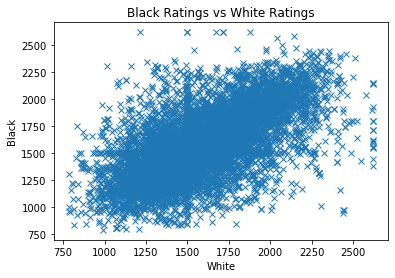

In [4]:
plt.plot(random_sample.white_rating,random_sample.black_rating,'x')
plt.title('Black Ratings vs White Ratings')
plt.xlabel('White')
plt.ylabel('Black')

# III. Method

Pocket algorithm is a perceptron based algorithm that checks for when the w it has 'in the pocket' is better than some new w. This allows it to avoid overfitting the data but can lead to issues with hill climb problems. QDA and LDA are extremely similar functions with the main difference being qda uses a curve and lda uses a line. This line/curve is used to project the points onto with the goal of maximising the diference of the means of the classes and minimizing the variance around those means. Finaly logistic regression uses a soft max function to update its w during training. It also requires your targets to be in one hot form in order to quantify categorical data. For my functions I chose not to use the super class because I am still fairly new to python and building my own classes on top of making sure I understood and could implement all the functions felt like too much to chew. I ended up defining each function as its own method and called them in my experiment section. For my pocket algorithm I used a for loop to itterate through my X1 and create new w's I would then use the compare method to check if my new w or pocket w was better and update accordingly. If for one full loop of N my pocket was always better I considered the function converged. For QDA and LDA I simply used the formulas provided in the notes to implement them. I broke them down into sections to allow for easier debugging. Finally for Logistic Regression I used the same formula from the note for my train function. For the soft max and get one hot functions I found those in stack overflow posts and modified them to fit my needs.

In [ ]:
import numpy as np
from abc import ABC, abstractmethod

# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)

        # TODO: Finish this normalization
        Xs = (X-self.mean)/self.std
        return Xs

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    def train(self, X, T):
        pass
    
    @abstractmethod
    def use(self, X):
        pass 

For the rest of implementation, inherit the class and make your own Pocket, QDA, LDA, and LogisticRegress classes. Each following subsection will have toy tests as we did in the note before applying to your data.

### B. Pocket Algorithm


In [5]:
from copy import deepcopy as copy
def compare(X, T, w, wp):
    y = np.sign(X @ w)
    yp = np.sign(X @ wp)
    return 1 if np.sum(y == T) >= np.sum(yp == T) else -1
def pocket(X1,T,alpha=0.1,maxiter=10000):
    N = X1.shape[0]
    w = np.zeros(X1.shape[1])
    w_pocket = copy(w)
    for i in range(maxiter):
        pocket_better=0
        converged = False
        for k in range(N):
            ##### TODO: add codes here
            w = w+(X1[k].dot(alpha).dot(T[k]))
            if compare(X1,T,w,w_pocket) == 1:
                w_pocket=copy(w)
            else:
                pocket_better+=1
        if pocket_better == N:
            converged=True

        if converged:
            print("converged at ", i)
            break
    
    plt.plot(X1@w_pocket)
    y=np.sign(X1 @ w_pocket)
    itter=0
    correct=0
    for predict in y:
        if(predict == T[itter]):
            correct+=1
    percCorrect = correct/T.shape[0]
    print('Percentage correct: %',percCorrect*100)
    return w_pocket

### C. QDA

In [6]:
def QDA(X, mu, sigma, prior):
    # TODO: finish the discriminant function here.
    y=np.array([])
    diffv=X-mu.T
    sigmaI=np.linalg.inv(sigma)
    detSigma=np.linalg.det(sigma)
    one=-.5*np.log(detSigma)
    two=-0.5 * np.sum(np.dot(diffv, sigmaI) * diffv, axis=1)
    three=np.log(prior)
    y=one+two+three
    return y

### D. LDA

In [7]:
def LDA(X, mu, sigma, prior):
    # TODO: finish the discriminant function here. 
    sigmaI=np.linalg.inv(sigma)
    one=mu@sigmaI@X.T
    two=-.5*mu.T@sigmaI@mu
    three=np.log(prior)
    return one+two+three

### E. Logistic Regression

In [8]:
import IPython.display as ipd
def g(X, w):
    K=X@w
    K-=np.max(K)
    sm = (np.exp(K).T / np.sum(np.exp(K),axis=1)).T
    return sm
def train(X1,Ttrain,w,alpha=0.01,niter=1000):
    for step in range(niter):
        # TODO: add training code here! 
        w+=alpha*X1.T@(Ttrain-g(X1,w))
    return w
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

# IV. Experiments

For my experiments I wanted to focus on the percentage accuracy of each individual algorithm and compare that for each to gauge which is the most acurate. Before I get into the individual ones and which is better I wanted to talk about one of my observations about the accuracy. For the most part all my algortihms guessed accurately 30-50% of the time. I believe this to be because my algorithms have reached local minima/maxima creating the hill climb problem. This could be fixed using some form of stochastic learning in the future. Now onto my individual experiments. The first thing I did was split the data into training and test data along with making X1's etc. Next we get into the pocket algorithm in which I simply ran the algoritm on my training data which gave me a training acuracy and a w for which to use on my test data. After that my QDA and LDA algorithms were derived pretty much exclusively from the note in which we learned them again adding and accuracy percentage. Finally the logistic regression is where I ran into most of my issues. They were mainly surrounding my soft max function which was incorrectly implemented in the note. Also I failed to convert my targets into one hot format which is something I had to learn how to do. Overall as I said for the most part my algorithms were accurate 30-50% of the time. However the logistic regression algorithm seemed to be at or above 50% most of the time. It is because of this I am determining it as the best algorithm to use for this data set.

In [9]:
#partition data
testX = np.array(random_sample[8000:])
trainX = np.array(random_sample[:8000])
testClass = np.array(classes[8000:])
trainClass= np.array(classes[:8000])
trainX1 = np.append(trainX, np.ones(trainX.shape[0])[...,None],1)
testX1 = np.append(testX, np.ones(testX.shape[0])[...,None],1)
testClass[testClass<0] += 1
trainClass[trainClass<0]+= 1
logTtrain=get_one_hot(trainClass,2)
logTtest= get_one_hot(testClass,2)
testClass = np.array(classes[8000:])
trainClass= np.array(classes[:8000])

converged at  1
Percentage correct: % 56.462500000000006


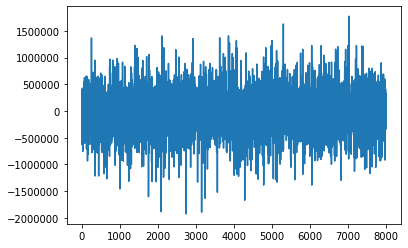

In [10]:
#Pocket train
w=pocket(trainX1,trainClass)

Percentage correct: % 57.45


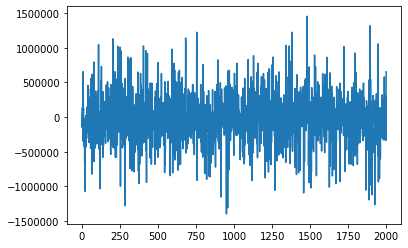

In [11]:
#Pocket Test
plt.plot(testX1 @ w)
y=np.sign(testX1 @ w)
itter=0
correct=0
for predict in y:
    if(predict == testClass[itter]):
        correct+=1
percCorrect = correct/testClass.shape[0]
print('Percentage correct: %',percCorrect*100)

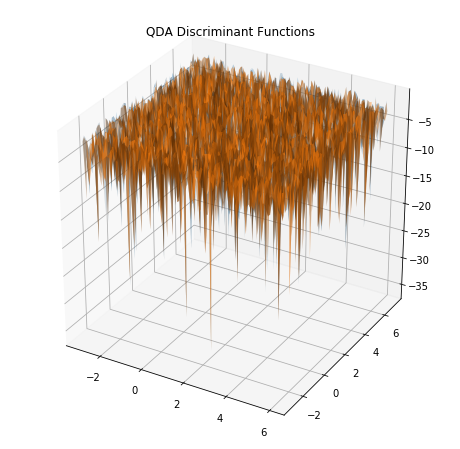

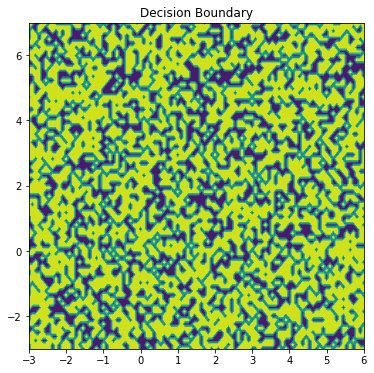

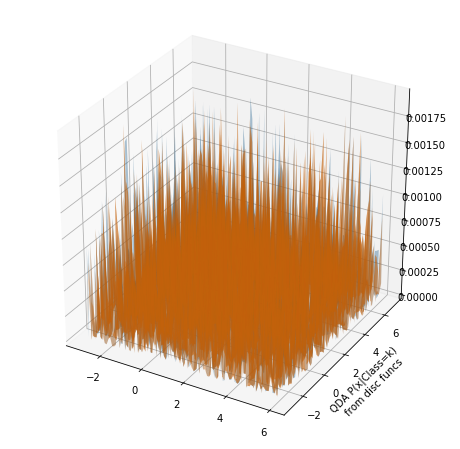

Percentage correct: % 43.225


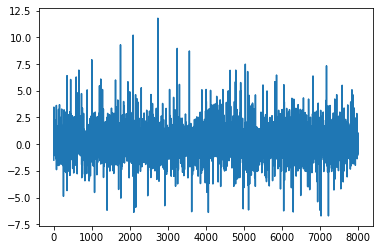

In [12]:
#Qda Train
N1 = trainX[trainClass==-1].shape[0]
N2 = trainX[trainClass==1].shape[0]
N = N1 + N2

means, stds = np.mean(trainX, 0), np.std(trainX, 0)
Xs = (trainX - means) / stds

mu1 = np.mean(Xs[trainClass==-1], 0)
mu2 = np.mean(Xs[trainClass==1], 0)

Sigma1 = np.cov(Xs[trainClass==-1].T)
Sigma2 = np.cov(Xs[trainClass==1].T)


prior1 = N1 / N
prior2 = N2 / N


xs, ys = np.meshgrid(np.linspace(-3,6, 100), np.linspace(-3,7, 80))
XtestS = (trainX-means)/stds
d1 = QDA(XtestS, mu1, Sigma1, prior1)
d2 = QDA(XtestS, mu2, Sigma2, prior2)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("QDA Discriminant Functions")

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, (d1-d2 > 0).reshape(xs.shape))
plt.title("Decision Boundary")

# Plot generative distributions  p(x | Class=k)  starting with discriminant functions

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

prob1 = np.exp( d1.reshape(xs.shape) - 0.5*trainX.shape[1]*np.log(2*np.pi) - np.log(prior1))
prob2 = np.exp( d2.reshape(xs.shape) - 0.5*trainX.shape[1]*np.log(2*np.pi) - np.log(prior2))
ax.plot_surface(xs, ys, prob1, alpha=0.2)
ax.plot_surface(xs, ys, prob2, alpha=0.4)


plt.ylabel("QDA P(x|Class=k)\n from disc funcs", multialignment="center")
plt.show()
predictions=d1-d2
plt.plot(predictions)
predictions[predictions<=0]=-1
predictions[predictions>0]=1

plt.show
itter=0
correct=0
for predict in predictions:
    if(predict == trainClass[itter]):
        correct+=1
percCorrect = correct/trainClass.shape[0]
print('Percentage correct: %',percCorrect*100)

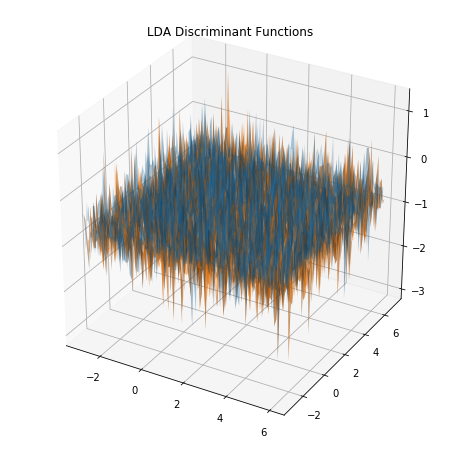

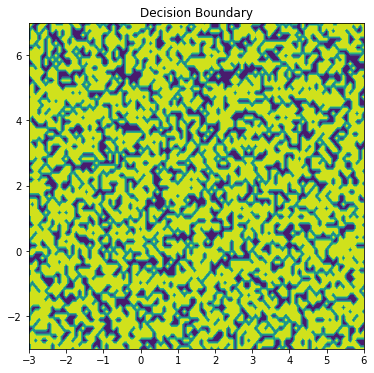

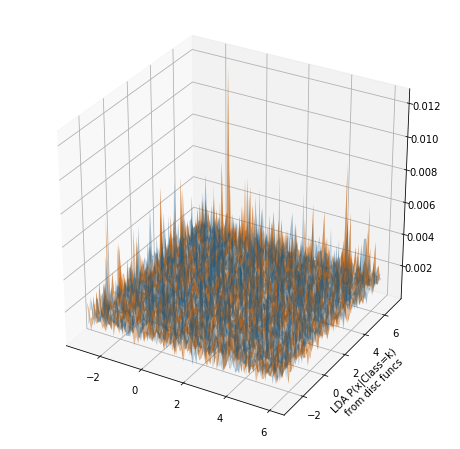

Percentage correct: % 39.800000000000004


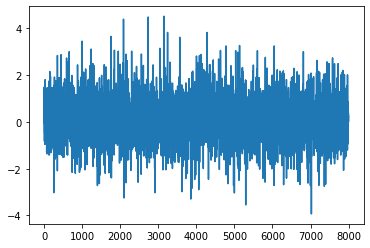

In [13]:
#lda
N1 = trainX[trainClass==-1].shape[0]
N2 = trainX[trainClass==1].shape[0]
N = N1 + N2

means, stds = np.mean(trainX, 0), np.std(trainX, 0)
Xs = (trainX - means) / stds

mu1 = np.mean(Xs[trainClass==-1], 0)
mu2 = np.mean(Xs[trainClass==1], 0)

Sigma = np.cov(Xs.T)


prior1 = N1 / N
prior2 = N2 / N


xs, ys = np.meshgrid(np.linspace(-3,6, 100), np.linspace(-3,7, 80))
XtestS = (trainX-means)/stds
d1 = LDA(XtestS, mu1, Sigma, prior1)
d2 = LDA(XtestS, mu2, Sigma, prior2)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("LDA Discriminant Functions")

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, (d1-d2 > 0).reshape(xs.shape))
plt.title("Decision Boundary")

# Plot generative distributions  p(x | Class=k)  starting with discriminant functions

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

prob1 = np.exp( d1.reshape(xs.shape) - 0.5*trainX.shape[1]*np.log(2*np.pi) - np.log(prior1))
prob2 = np.exp( d2.reshape(xs.shape) - 0.5*trainX.shape[1]*np.log(2*np.pi) - np.log(prior2))
ax.plot_surface(xs, ys, prob1, alpha=0.2)
ax.plot_surface(xs, ys, prob2, alpha=0.4)


plt.ylabel("LDA P(x|Class=k)\n from disc funcs", multialignment="center")
plt.show()
predictions=d1-d2
plt.plot(predictions)
predictions[predictions<=0]=-1
predictions[predictions>0]=1


plt.show
itter=0
correct=0
for predict in predictions:
    if(predict == trainClass[itter]):
        correct+=1
percCorrect = correct/trainClass.shape[0]
print('Percentage correct: %',percCorrect*100)

Accuracy:  57.65 %


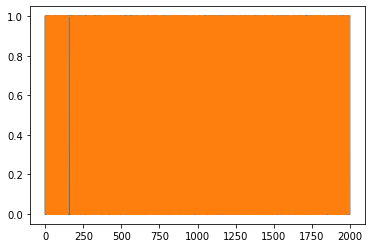

In [14]:
#logistic regression

means, stds = np.mean(trainX, 0), np.std(trainX, 0)
# normalize inputs
Xtrains = (trainX - means) / stds
trainX1 = np.append(Xtrains, np.ones(trainX.shape[0])[...,None],1)
means,stds = np.mean(testX, 0), np.std(testX, 0)
Xtests = (testX-means)/stds
testX1 = np.append(Xtests, np.ones(testX.shape[0])[...,None],1)
w = np.random.rand(trainX1.shape[1], 2)

w=train(trainX1,logTtrain,w)
Y = g(testX1, w)
Yl = np.argmax(Y, 1)
Tl = np.argmax(logTtest, 1)
plt.plot(Tl)
plt.plot(Yl)
print("Accuracy: ", 100 - np.mean(np.abs(Tl - Yl)) * 100, "%")

# Conclusions

Overall this assignment wasnt too bad as far as challenges go and I did learn a lot. My biggest challenges surrounded the logistic regression algorithm due to some logic errors in my original implementation. This forced me to reformat part of the algorithm and seek help from the TA's. The help from the TA's was the cornerstone in fixing this issue. The one thing I wish this assignment had was a section of tests to compare your algorithms against to say with 100% certainty wether or not you implemented them correctly. As I mentioned in the methods section I believe that logistic regression was my most accurate data set for the data I had with an average accuracy of 50-60%. 

# References
Abhijay GhildyalAbhijay Ghildyal 3, et al. “One Hot Encoding Using Numpy.” Stack Overflow, 1 Oct. 1965, 
    stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy. 
J, Mitchell. “Chess Game Dataset (Lichess).” Kaggle, 4 Sept. 2017, www.kaggle.com/datasnaek/chess. 
Juliani, Arthur. “Simple Softmax Regression in Python - Tutorial.” Medium, Medium, 22 Feb. 2016, 
    medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16. 

# Extra Credit

* [OPT 1] Search for a ordinal data set and apply your classifiers to it. 
  - Repeat the experiments on it. 
  - Do you have different observation from previous results? 
  - Were you able to observe that we discussed in class about logistic regression? 
  - For a full extra credit point, you need to discuss all bullet points in Results section.     


* [OPT 2] Partition your data into five sets. Selecting one test set and the other for training, repeat your experiments and observe/analyze the 5 different training/testing errors.  

## Grading

DO NOT forget to submit your data! Your notebook is supposed to run well after running your codes.

To help our TA's grading, please make an explicit section for each grading criteria. 

** Note: this is a WRITING assignment. Proper writing is REQUIRED. Comments are not considered as writing. ** 



points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
15 | Data | 
 | 5| description 
 | 5| plots for understanding or analysis 
 | 5| preliminary observation 
25 | Methods | 
 |10| Summary of Classification models
 | 5| Explanation of codes
 |10| Pocket, LDA, QDA, Logistic Regression
40 | Experiments 
| 5| Discussion about evaluation metrics
| 5| Discussion about train and test accuracies
|20| plots for results (5 for each algorithm)
|10| Discussions about classificaion model comparison
5 | |Conclusions 
5 | |Referemces
5 | |Grammar and spelling error (Proofread please)